In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
# import modules
import  visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load network from pickle
model_date = "['202204']"
location = 'stavanger'
DP_tol = 30
min_samples = 30
data_size = 'full'
refined = '_refined'

#model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+data_size+'_UTM'+refined
model_name = model_date+'_waypoints_DP10_DBSCAN10_eps50_stavanger_full_UTM'
model_path = '../../models/networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': "['../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_3.parquet']",
 'DP_tolerance': 10,
 'clustering_method': 'DBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 10,
 'clustering_min_cluster_size': 10,
 'clustering_eps': 50,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45,
 'merge_stops_speed': 2}

In [4]:
# plot network and basemap
#network.prune_graph(5, 'refined')
map = network.map_graph(pruned=True, line_weight=2, min_passages=3)  #tromso: center=[69, 19], oslo: center=[59, 10.5]

# add some trajectories
all_trajectories = network.trajectories
selection_start = 0
selection_end = 1 #len(all_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
#selection = [0, 1, 10, 100, 500, 1000, 2999, 5000]
mmsis = network.gdf.mmsi.unique()[selection]
#mmsis = test_gdf.mmsi.unique()[selection]
#mmsis = ['257062150_2_2022-04-19 20:22:52']
#trajectories = all_trajectories.filter('mmsi', mmsis.tolist())
for mmsi in mmsis:
    print(mmsi)
    trajectory = all_trajectories.get_trajectory(mmsi)
    path_df_sspd, evaluation_results_sspd = network.trajectory_to_path_sspd(trajectory, verbose=False)
    print(evaluation_results_sspd[['message', 'SSPD']])
    print('------------------')
    try:
        map = trajectory.to_line_gdf()[['geometry', 'mmsi', 'skipsgruppe']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1}, 
                                                                      name=mmsi+' trajectory')
        map = path_df_sspd.explore(m=map, name=mmsi+' edge_sequence sspd', style_kwds={'weight':3, 'color':'cyan', 'opacity':1})
    except:
        print(mmsi+': no path found')

bbox = visualize.get_bounding_box(network.gdf)
map = bbox.explore(m=map, color='red', name='bounds')
folium.LayerControl().add_to(map)
#map

205209000_0_2022-04-08 03:12:48
   message        SSPD
0  success  267.287231
------------------


In [5]:
map.save('../../reports/maps/'+model_name+'.html')
print(f'Map saved under {"../../reports/maps/"+model_name+".html"}')

Map saved under ../../reports/maps/['202204']_waypoints_DP10_DBSCAN10_eps50_stavanger_full_UTM.html


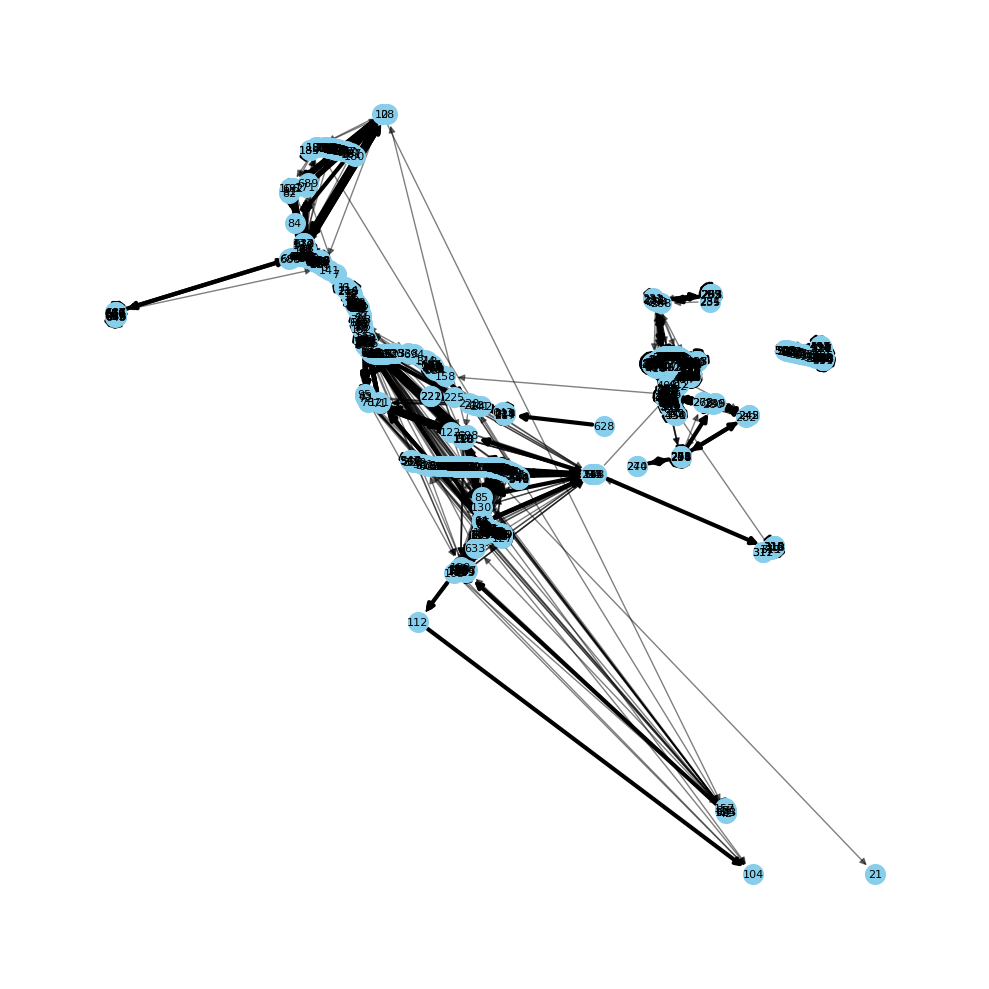

In [6]:
network.plot_graph_canvas(refined=False)

In [7]:
conn = network.waypoint_connections_refined
rows_with_nan = conn[conn.isna().any(axis=1)]
rows_with_nan.head(30)

AttributeError: 'list' object has no attribute 'isna'